## survey results

In [ ]:
import pandas as pd 
import io
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
DATA_FILE   = "../output/survey_results/all_participants_ratings.csv"        # original wide file
OUTPUT_DIR  = Path("../output/survey_results")   

def load_data(csv_path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    likert_cols = [c for c in df.columns if c != "participant"]
    df[likert_cols] = df[likert_cols].astype(int)
    return df

def make_item_text_table() -> pd.DataFrame:
    items = [
        ("U1", "Usability",
         "I found the chatbot easy to use."),
        ("U2", "Usability",
         "Interacting with the chatbot was clear and understandable."),
        ("U3", "Usability",
         "The chatbot responded quickly to my inputs."),
        ("U4", "Usability",
         "I would like to use this chatbot regularly."),
        ("U5", "Usability",
         "I was able to start using the chatbot right away."),
        ("T1", "Trust",
         "I trusted the information provided by the chatbot."),
        ("T2", "Trust",
         "The chatbot clearly indicated when it was uncertain."),
        ("T3", "Trust",
         "I trusted the chatbot to tell me when it was unsure."),
        ("T4", "Trust",
         "Seeing the chatbot’s confidence score affected how much I relied on its answers."),
        ("T5", "Trust",
         "The sources provided by the chatbot helped me verify its answers."),
    ]
    return pd.DataFrame(items, columns=["code", "section", "statement"])

def to_long(df_wide: pd.DataFrame, items_df: pd.DataFrame) -> pd.DataFrame:
    return (
        df_wide.melt(id_vars="participant", var_name="code", value_name="score")
               .merge(items_df, on="code")
               .loc[:, ["participant", "section", "code", "statement", "score"]]
    )

# wrangle csv's
df_wide = load_data(DATA_FILE)

items_df = make_item_text_table()
items_df.to_csv(OUTPUT_DIR / "likert_items.csv", index=False)

long_df = to_long(df_wide, items_df)
long_df.to_csv(OUTPUT_DIR / "chatbot_survey_long.csv", index=False)

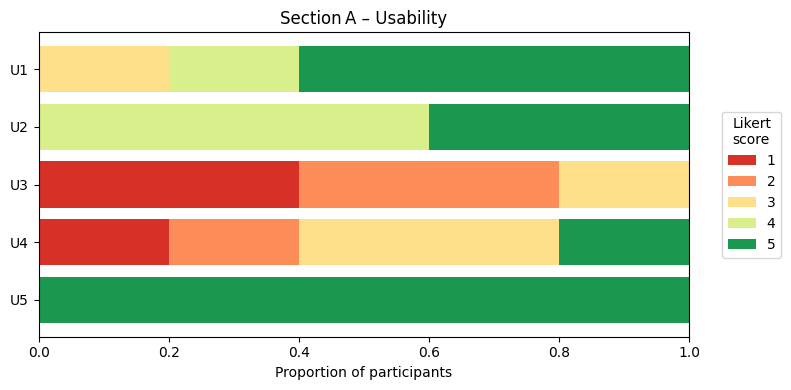

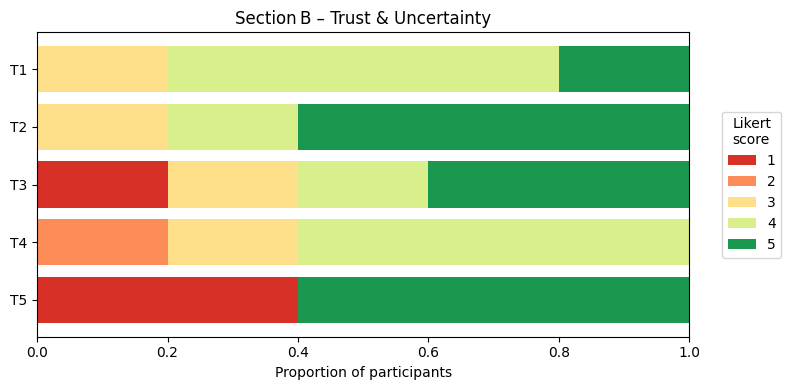

In [26]:

def item_summary(df_wide: pd.DataFrame, codes: list[str]) -> pd.DataFrame:
    rows = []
    for col in codes:
        cnt = (df_wide[col]
               .value_counts()
               .reindex([1, 2, 3, 4, 5], fill_value=0))
        rows.append({
            "item": col,
            **{f"n{sc}": cnt.loc[sc] for sc in cnt.index},
            "median": df_wide[col].median(),
            "mode":   df_wide[col].mode().iat[0],
        })
    return pd.DataFrame(rows)

def plot_stacked_bar(df_wide: pd.DataFrame,
                     codes: list[str],
                     title: str,
                     colors=None,
                     fname: str | None = None):
    if colors is None:  # red → green gradient
        colors = ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#1a9850"]
    codes = codes[::-1]          # 1 at top, 5 at bottom
    prop = pd.DataFrame([
        (df_wide[c].value_counts()
                  .reindex([1, 2, 3, 4, 5], fill_value=0).values / len(df_wide))
        for c in codes
    ], index=codes, columns=[1, 2, 3, 4, 5])

    plt.figure(figsize=(8, 4))
    left = pd.Series([0]*len(prop), index=prop.index)
    for score, col in zip([1, 2, 3, 4, 5], colors):
        plt.barh(prop.index, prop[score], left=left,
                 label=score, color=col)
        left += prop[score]

    #plt.yticks([])      # blank labels 
    plt.xlim(0, 1)
    plt.xlabel("Proportion of participants")
    plt.title(title)
    plt.legend(title="Likert\nscore", bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()


us_codes  = ["U1", "U2", "U3", "U4", "U5"]
tr_codes  = ["T1", "T2", "T3", "T4", "T5"]

us_item = item_summary(df_wide, us_codes)
us_item.to_csv(OUTPUT_DIR / "usability_item_summary.csv", index=False)
tr_item = item_summary(df_wide, tr_codes)
tr_item.to_csv(OUTPUT_DIR / "trust_item_summary.csv",index=False)

plot_stacked_bar(df_wide, us_codes,
                 "Section A – Usability",
                 fname=OUTPUT_DIR / "lab_usability_stacked.png")
plot_stacked_bar(df_wide, tr_codes,
                 "Section B – Trust & Uncertainty",
                 fname=OUTPUT_DIR / "lab_trust_stacked.png")


In [28]:
import numpy as np

# Define which items belong to each section
usability_items = ["U1", "U2", "U3", "U4", "U5"]
trust_items     = ["T1", "T2", "T3", "T4", "T5"]

# Compute per-participant averages (section scores)
df_wide["usability_score"] = df_wide[usability_items].mean(axis=1)
df_wide["trust_score"]     = df_wide[trust_items].mean(axis=1)

# Calculate group-level summary stats
us_median = df_wide["usability_score"].median()
us_iqr    = np.subtract(*np.percentile(df_wide["usability_score"], [75, 25]))

tr_median = df_wide["trust_score"].median()
tr_iqr    = np.subtract(*np.percentile(df_wide["trust_score"], [75, 25]))

print(f"Usability – Median: {us_median:.2f}, IQR: {us_iqr:.2f}")
print(f"Trust     – Median: {tr_median:.2f}, IQR: {tr_iqr:.2f}")


Usability – Median: 3.60, IQR: 0.40
Trust     – Median: 3.60, IQR: 0.80


## ue method results

In [12]:

import numpy as np, pandas as pd, scipy.stats as ss
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

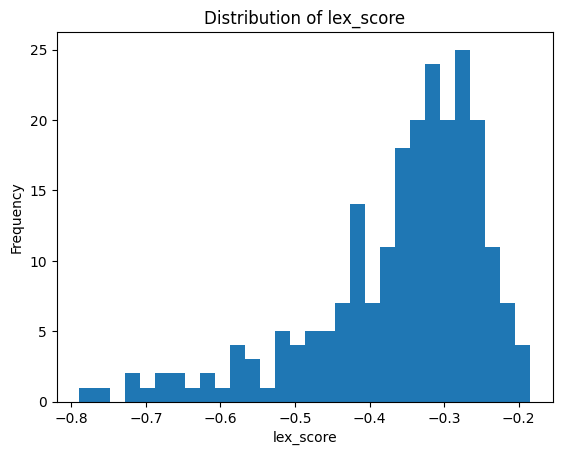

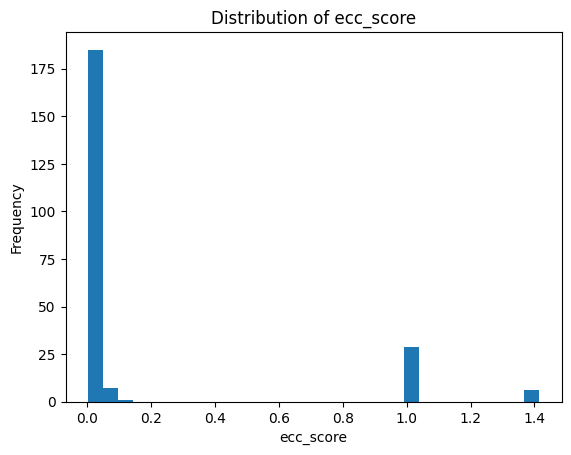

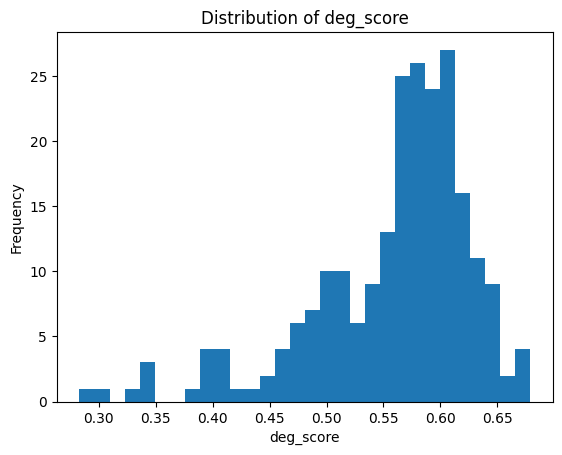

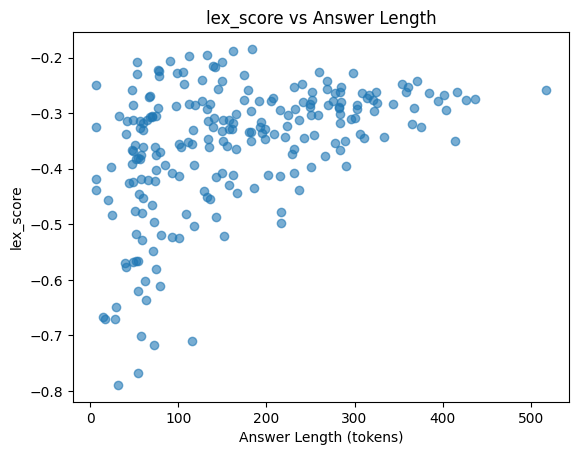

Spearman ρ(length, lex_score) = 0.457 (p = 3.573e-13)


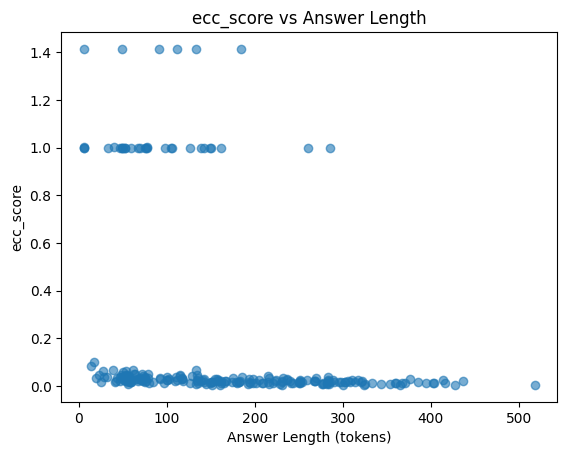

Spearman ρ(length, ecc_score) = -0.585 (p = 2.659e-22)


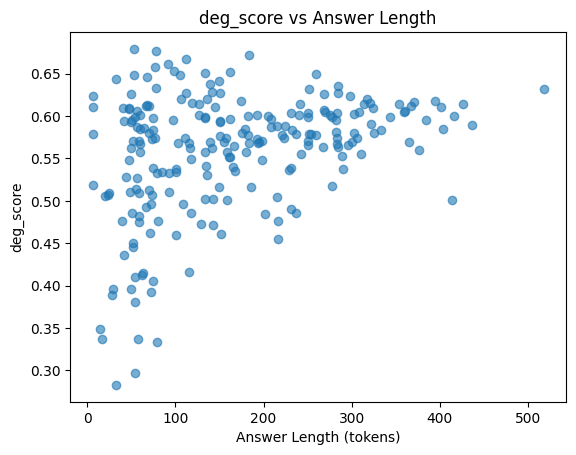

Spearman ρ(length, deg_score) = 0.297 (p = 4.958e-06)


In [ ]:


df = pd.read_csv("../output/quantitative_metrics/all_scalers_testset.csv")

# Answer length in *tokens* (white‑space split)
df["answer_len"] = df["final_answer"].str.split().str.len()

# DISTRIBUTION PLOTS (one plot per metric)
metrics = ["lex_score", "ecc_score", "deg_score"]
for m in metrics:
    plt.figure()
    plt.hist(df[m].dropna(), bins=30)
    plt.title(f"Distribution of {m}")
    plt.xlabel(m)
    plt.ylabel("Frequency")
    plt.show()

# LENGTH vs UNCERTAINTY SCATTERS 
for m in metrics:
    plt.figure()
    plt.scatter(df["answer_len"], df[m], alpha=0.6)
    plt.title(f"{m} vs Answer Length")
    plt.xlabel("Answer Length (tokens)")
    plt.ylabel(m)
    plt.show()

    # print Spearman rank correlation
    rho, p = ss.spearmanr(df["answer_len"], df[m])
    print(f"Spearman ρ(length, {m}) = {rho:.3f} (p = {p:.3e})")


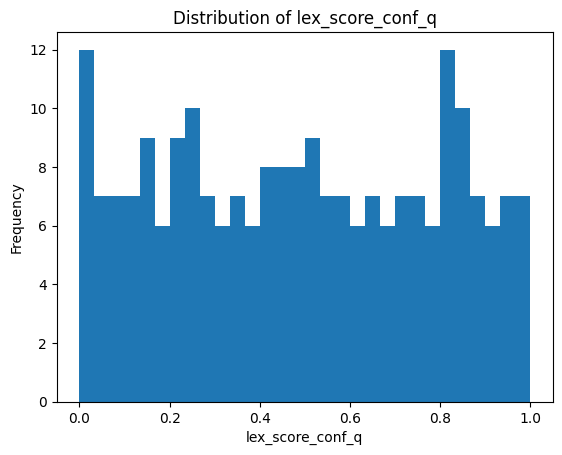

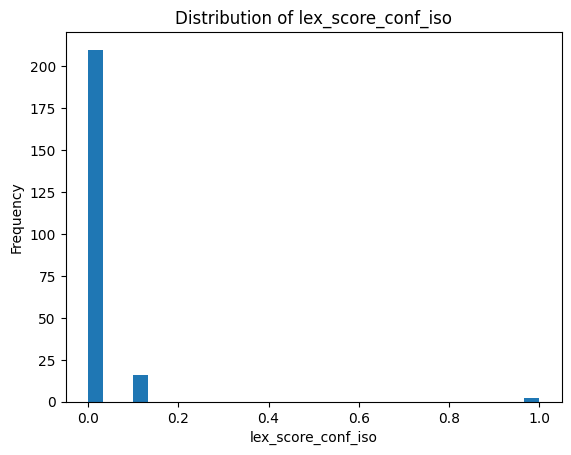

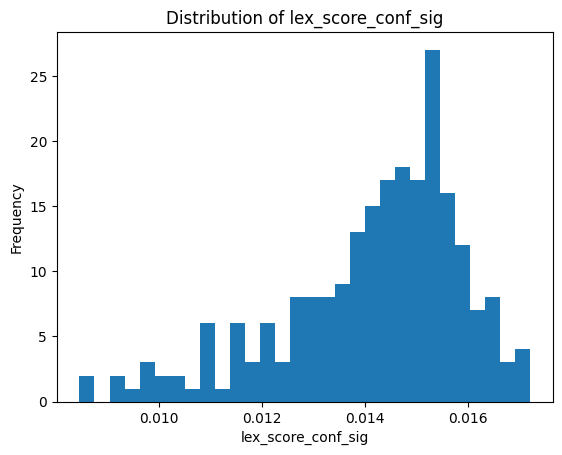

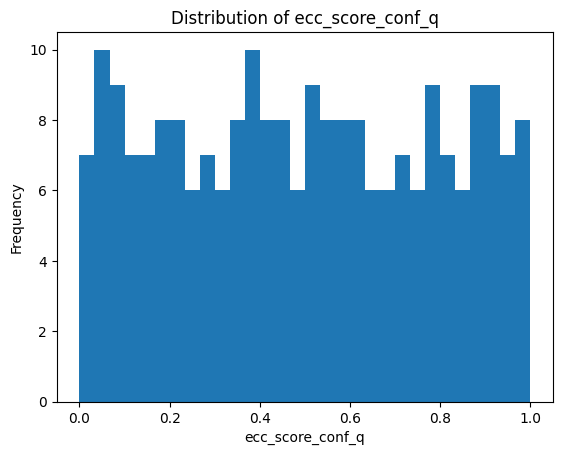

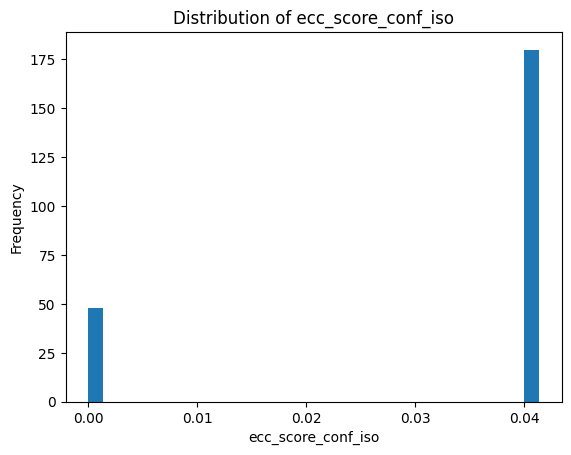

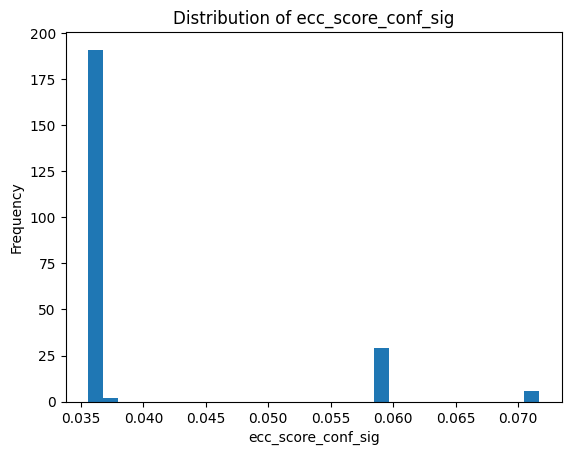

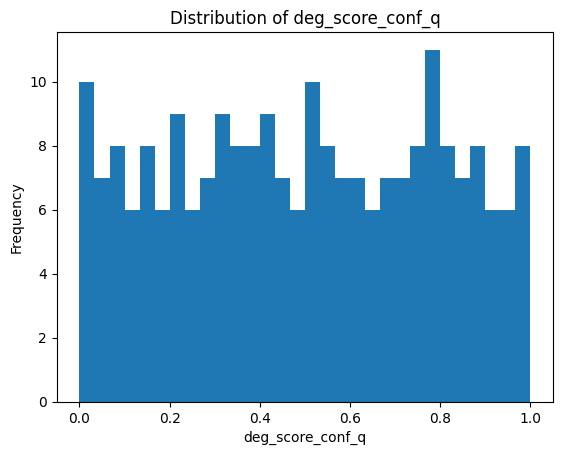

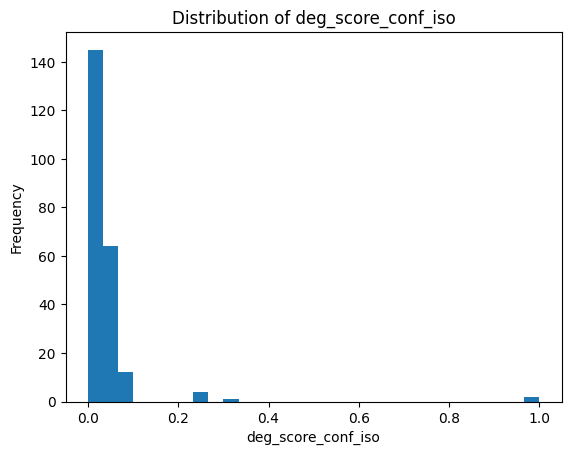

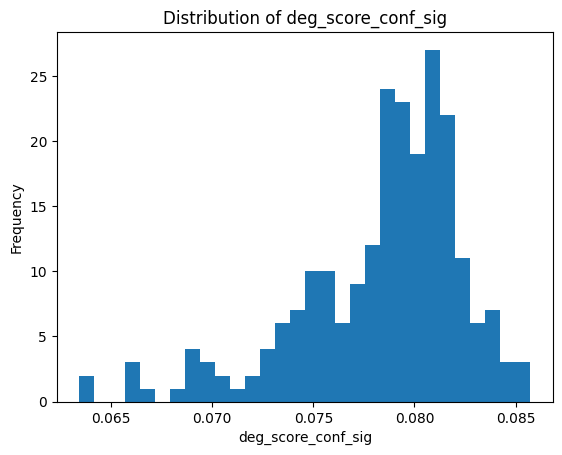

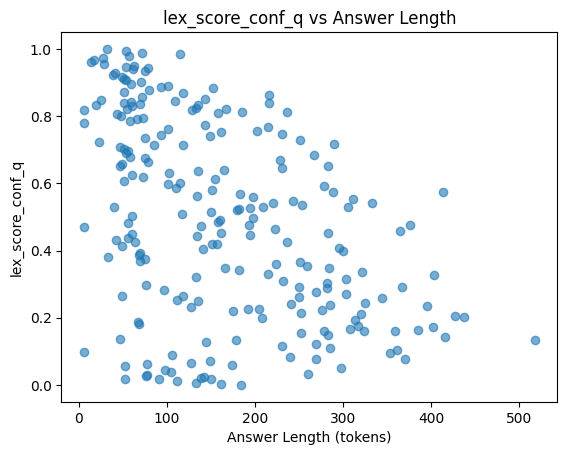

Spearman ρ(length, lex_score_conf_q) = -0.457 (p = 3.573e-13)


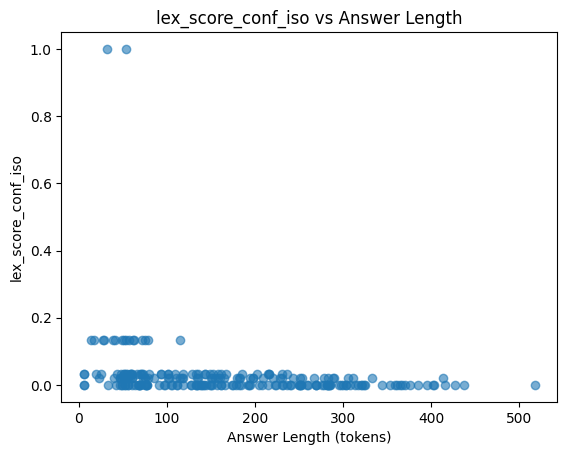

Spearman ρ(length, lex_score_conf_iso) = -0.457 (p = 3.794e-13)


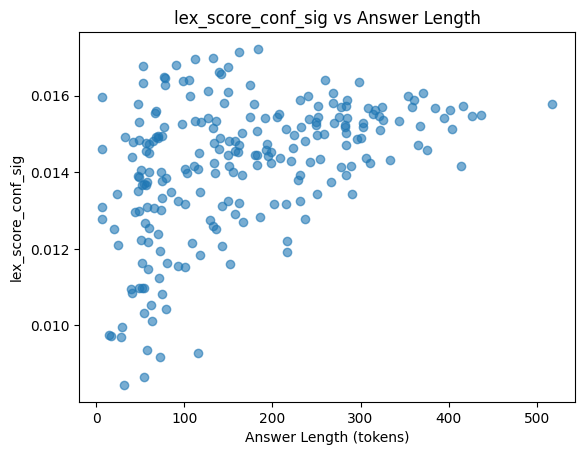

Spearman ρ(length, lex_score_conf_sig) = 0.457 (p = 3.573e-13)


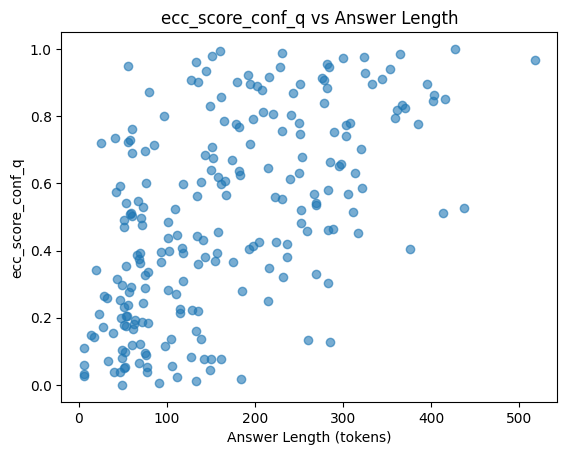

Spearman ρ(length, ecc_score_conf_q) = 0.585 (p = 2.659e-22)


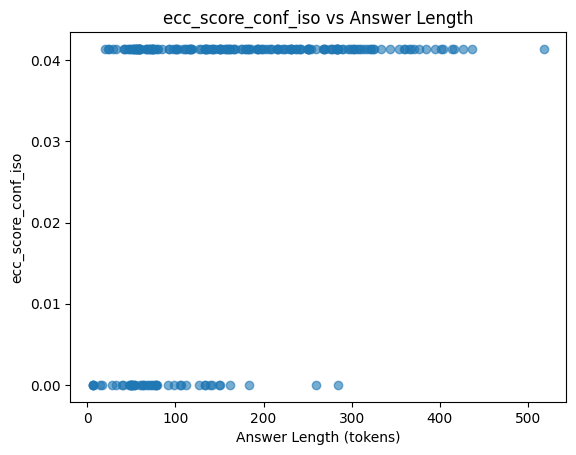

Spearman ρ(length, ecc_score_conf_iso) = 0.421 (p = 3.326e-11)


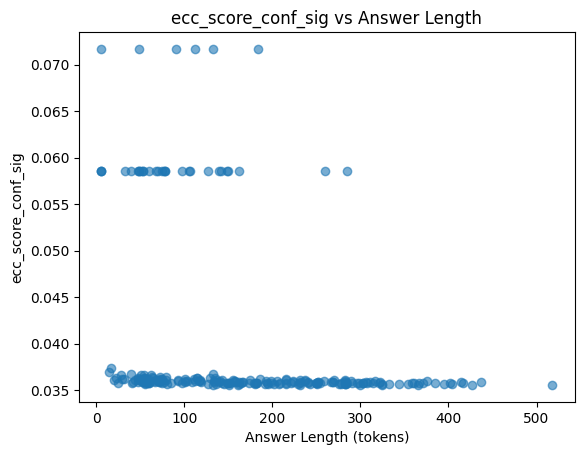

Spearman ρ(length, ecc_score_conf_sig) = -0.585 (p = 2.659e-22)


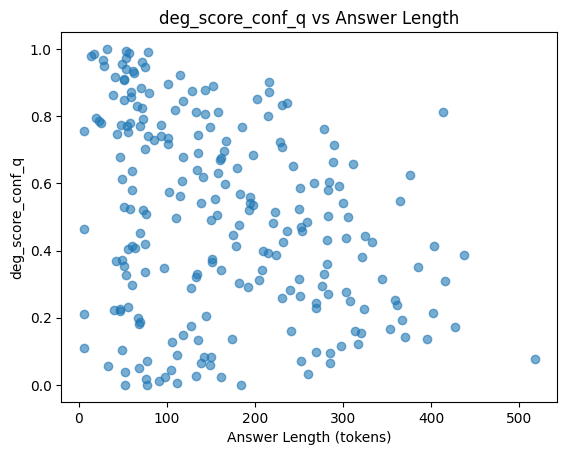

Spearman ρ(length, deg_score_conf_q) = -0.297 (p = 4.916e-06)


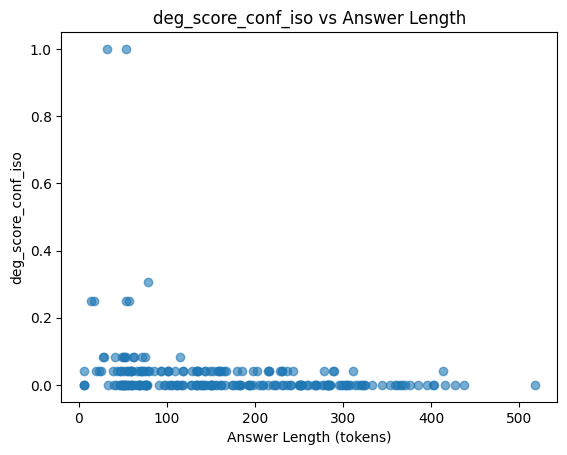

Spearman ρ(length, deg_score_conf_iso) = -0.384 (p = 2.099e-09)


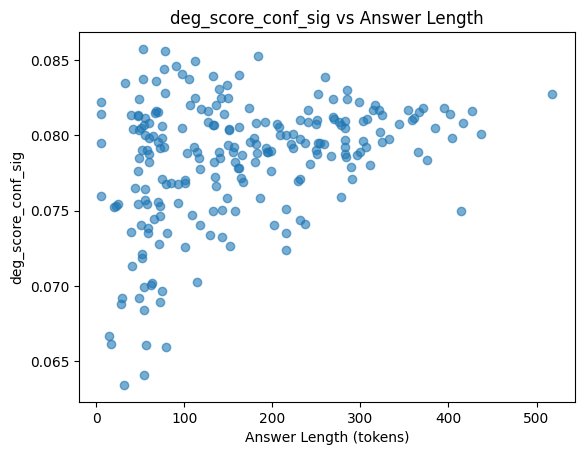

Spearman ρ(length, deg_score_conf_sig) = 0.297 (p = 4.958e-06)


In [23]:
# same plots with scaled values

# Answer length in *tokens* (white‑space split)
df["answer_len"] = df["final_answer"].str.split().str.len()

# ---------- 1. DISTRIBUTION PLOTS (one plot per metric) ----------
metrics = ["lex_score_conf_q", "lex_score_conf_iso", "lex_score_conf_sig", "ecc_score_conf_q",  "ecc_score_conf_iso","ecc_score_conf_sig","deg_score_conf_q", "deg_score_conf_iso","deg_score_conf_sig"]
for m in metrics:
    plt.figure()
    plt.hist(df[m].dropna(), bins=30)
    plt.title(f"Distribution of {m}")
    plt.xlabel(m)
    plt.ylabel("Frequency")
    plt.show()

# ---------- 2. LENGTH vs UNCERTAINTY SCATTERS ----------
for m in metrics:
    plt.figure()
    plt.scatter(df["answer_len"], df[m], alpha=0.6)
    plt.title(f"{m} vs Answer Length")
    plt.xlabel("Answer Length (tokens)")
    plt.ylabel(m)
    plt.show()

    # Optional: print Spearman rank correlation in the notebook output.
    rho, p = ss.spearmanr(df["answer_len"], df[m])
    print(f"Spearman ρ(length, {m}) = {rho:.3f} (p = {p:.3e})")


### alignscore results

=== Spearman ρ (UE ↓  vs  AlignScore ↑) ===
lex_score        ρ = +0.018   p = 7.82e-01
ecc_score        ρ = +0.047   p = 4.83e-01
deg_score        ρ = +0.093   p = 1.62e-01

=== PRR ===
lex_score        PRR = +0.156
ecc_score        PRR = +0.161
deg_score        PRR = +0.217

=== Binary AUROC (good = AlignScore >= 0.7) ===
lex_score        AUROC = 0.883
ecc_score        AUROC = 0.909
deg_score        AUROC = 0.897

=== ECE on held‑out test fold (lower is better) ===
lex_score        ECE = 0.212
ecc_score        ECE = 0.187
deg_score        ECE = 0.238
 ---

Spearman ρ ≈ 0.3 → UE is mildly correlated with factual quality; ρ ≤ 0 shows the ranking is broken.

PRR > 0.2 on only 220 answers is a respectable signal; < 0 means you’d do worse than random by trusting that UE score.

AUROC ≥ 0.7 indicates the score can separate good vs bad answers fairly well at some threshold.

ECE ≤ 0.1 on the 20 % hold‑out set suggests reasonable calibration; large ECE flags that the raw UE numbers aren’t usable as probabilities without extra scaling.

In [ ]:
df = pd.read_csv("../output/quantitative_metrics/all_scalers_testset.csv")

# Add BLEU (sentence‑level) & ROUGE‑L‑F1 columns
bleu_metric  = BLEU(tokenize='13a', effective_order=True)  
rl_scorer    = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def rouge_l_f1(pred, ref):
    return rl_scorer.score(ref, pred)['rougeL'].fmeasure       # 0‑1

df["bleu"]     = [bleu_metric.sentence_score(sys, [ref]).score / 100
                  for sys, ref in zip(df["final_answer"], df["reference"])]
df["rouge_l"]  = [rouge_l_f1(sys, ref)
                  for sys, ref in zip(df["final_answer"], df["reference"])]


# Configure UE columns and quality metrics (+ thresholds)
ue_cols   = ["lex_score", "ecc_score", "deg_score"]
qual_cfgs = {
    "alignscore": 0.70,   # factual‑consistency “good” cut‑off
    "bleu":       0.20,   # surface‑overlap “good” cut‑off
    "rouge_l":    0.25    # sentence‑LCS “good” cut‑off
}

#  Prediction–Rejection Ratio
def prr(quality, uncertainty, higher_quality_better=True):
    q = quality if higher_quality_better else -quality
    # coverage‑sorted areas
    def area(vals):                      # vals sorted *descending* quality
        csum = np.cumsum(vals)
        cov  = np.arange(1, len(vals)+1) / len(vals)
        return np.trapz(csum / np.arange(1, len(vals)+1), cov)

    oracle_area  = area(np.sort(q)[::-1])
    random_area  = q.mean()                   # flat line over coverage
    ue_area      = area(q[np.argsort(uncertainty)])
    return (ue_area - random_area) / (oracle_area - random_area + 1e-12)


rows = []          # gather result rows here

for qual, thr in qual_cfgs.items():
    quality = df[qual]
    good    = (quality >= thr).astype(int)

    for ue in ue_cols:
        # Spearman (UE ↓ vs quality ↑) – negate UE so higher rank = better
        rho, p = ss.spearmanr(-df[ue], quality)

        # PRR   (quality first, UE second) – correct order!
        prr_val = prr(quality.values, df[ue].values)

        # AUROC (UE ↓ so pass -UE)
        auroc   = roc_auc_score(good, -df[ue])

        rows.append({
            "quality_metric": qual,
            "ue_metric":      ue,
            "spearman_rho":   round(rho, 3),
            "prr":            round(prr_val, 3),
            "auroc":          round(auroc, 3)
        })


results_df = pd.DataFrame(rows)
display(results_df)               
results_df.to_csv("../output/quantitative_metrics/ue_metrics_overview.csv", index=False)
print("\nSaved to ue_metrics_overview.csv ")


,quality_metric,ue_metric,spearman_rho,prr,auroc
0,alignscore,lex_score,0.018,0.156,0.883
1,alignscore,ecc_score,0.262,0.104,0.417
2,alignscore,deg_score,0.093,0.217,0.897
3,bleu,lex_score,0.347,0.512,0.811
4,bleu,ecc_score,0.076,-0.094,0.392
5,bleu,deg_score,0.379,0.533,0.754
6,rouge_l,lex_score,0.448,0.570,0.756
7,rouge_l,ecc_score,0.053,-0.100,0.445
8,rouge_l,deg_score,0.442,0.570,0.725



Saved to ue_metrics_overview.csv 


### calibration results

In [ ]:
df = pd.read_csv("../output/quantitative_metrics/all_scalers_testset.csv")


# only using the 20 % test fold that the quantile scaler never saw
test_mask = df["split"] == "test"
n_bins = 10

def ece(prob, label, n_bins=10):
    bins = pd.qcut(prob, q=n_bins, duplicates="drop")
    ece_val = 0.0
    for b in bins.unique():
        mask = bins == b
        if mask.any():
            conf = prob[mask].mean()
            acc  = label[mask].mean()
            ece_val += np.abs(acc - conf) * mask.mean()
    return ece_val

print("\n=== ECE on held‑out test fold (lower is better) ===")
for m in ue_cols:
    # rescale UE to (0,1] confidence by min‑max inversion
    conf = 1.0 - (df.loc[test_mask, m]  - df[m].min()) / (df[m].max() - df[m].min())
    lab  = df.loc[test_mask, "is_good"]
    print(f"{m:15s}  ECE = {ece(conf.values, lab.values, n_bins):.3f}")


=== ECE on held‑out test fold (lower is better) ===


KeyError: 'is_good'

In [21]:
# ---------- 0. config ----------
ue_cols   = ["lex_score", "ecc_score", "deg_score"]
n_bins    = 10
test_mask = df["split"] == "test"
labels    = (df["alignscore"] >= 0.70).astype(int)       # good‑answer flag

def ece(prob, label, n_bins=10):
    """Vectorised Expected Calibration Error."""
    bins = pd.qcut(prob, q=n_bins, duplicates="drop")
    ece_val = 0.0
    for b in bins.unique():
        mask = bins == b
        if mask.any():
            conf = prob[mask].mean()
            acc  = label[mask].mean()
            ece_val += np.abs(acc - conf) * mask.mean()
    return ece_val

# ---------- 1. compute & print ----------
print("\n=== ECE on held‑out 20 % test split ===")
header = f"{'UE':12s} | {'raw_minmax':>10} | {'quantile':>8} | {'isotonic':>8}"
print(header)
print("-"*len(header))

for m in ue_cols:
    # 1) raw min‑max rescale (0‑1)
    lo, hi = df[m].min(), df[m].max()
    raw_conf = 1.0 - (df.loc[test_mask, m] - lo) / (hi - lo + 1e-12)

    # 2) quantile confidence (f'{col}_conf_q')
    q_conf = df.loc[test_mask, f"{m}_conf_q"]

    # 3) isotonic confidence (f'{col}_conf_iso')
    iso_conf = df.loc[test_mask, f"{m}_conf_iso"]

    # sig conf
    sig_conf = df.loc[test_mask, f"{m}_conf_sig"]

    ece_raw = ece(raw_conf.values, labels.loc[test_mask].values, n_bins)
    ece_q   = ece(q_conf.values, labels.loc[test_mask].values, n_bins)
    ece_iso = ece(iso_conf.values, labels.loc[test_mask].values, n_bins)
    ece_sig  = ece(sig_conf.values, labels.loc[test_mask].values, n_bins)


    print(f"{m:12s} | {ece_raw:10.3f} | {ece_q:8.3f} | {ece_iso:8.3f} | {ece_sig:8.3f}")



=== ECE on held‑out 20 % test split ===
UE           | raw_minmax | quantile | isotonic
-----------------------------------------------
lex_score    |      0.212 |    0.407 |    0.035 |    0.055
ecc_score    |      0.807 |    0.440 |    0.012 |    0.068
deg_score    |      0.238 |    0.433 |    0.025 |    0.090
